In [1]:
#support imports
import os
import h5py
import random

#packages that help with plotting
import matplotlib.pyplot as plt
import scipy.stats as stats

#torch imports
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF

In [41]:
device = "cuda"

In [2]:
class HDF5Dataset(Dataset):
    def __init__(self, file_path,transform=None):
        self.file_path = file_path
        self.hdf5_file = h5py.File(file_path,'r')
        self.images = self.hdf5_file['X']
        self.labels = self.hdf5_file['y']
        self.transform = transform
    
    def __len__(self):
        return(len(self.labels))
    
    def __getitem__(self,idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
            
        return image,label

In [3]:
#custom transform to reshape the image tensor

class ReshapeImage(object):
    def __call__(self,image):
        return image.permute(2,0,1)

In [27]:
electron_transform = transforms.Compose([
    ReshapeImage(),
])

photon_transform = transforms.Compose([
    ReshapeImage(),
    transforms.CenterCrop(16),
    transforms.Pad(padding=8),
])


In [28]:
electron_dataset = HDF5Dataset('./data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', transform=electron_transform)
photon_dataset = HDF5Dataset('./data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5',transform=photon_transform)

In [38]:
print(f"Number of Electron class images: {electron_dataset.__len__()}\nNumber of Photon class images: {photon_dataset.__len__()}")

Number of Electron class images: 249000
Number of Photon class images: 249000


Equal class distribution. Thats great!

In [39]:
#function to plot some images to see how the dataset entities look like
def show_images(dataset ,num_images=3):
    fig,axes = plt.subplots(1, num_images, figsize=(15,5))
    
    for i in range(num_images):
        idx = random.randint(0,len(dataset)-1)
        
        image,_ = dataset.__getitem__(idx)
        image_pil = TF.to_pil_image(image)
        axes[i].imshow(image_pil, cmap='binary')
        axes[i].set_title(f"{idx}")
        
    plt.show()

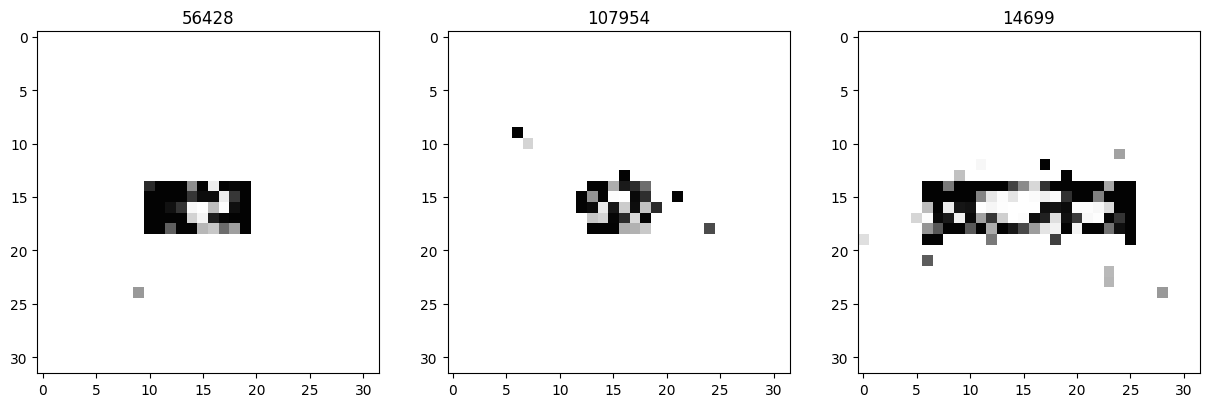

In [34]:
show_images(electron_dataset)

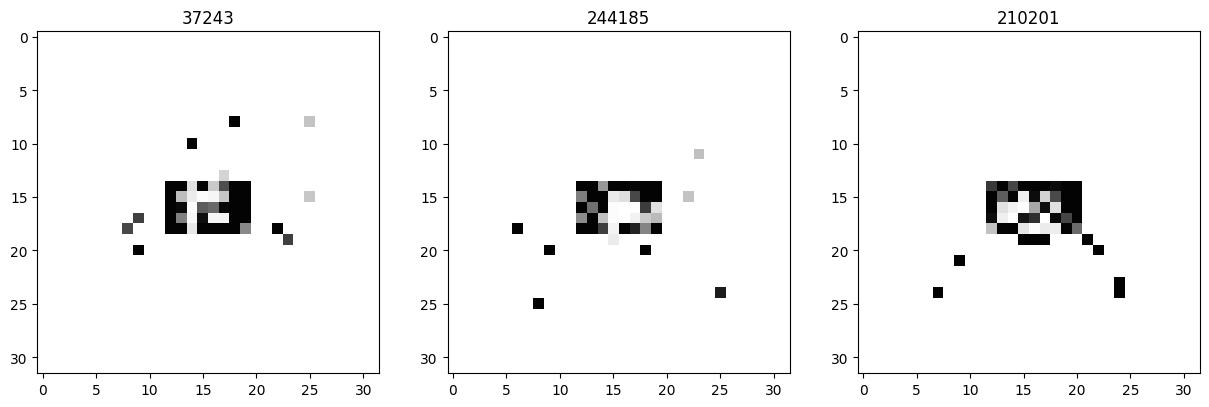

In [35]:
show_images(photon_dataset)


Two different transoforms are used for each class. This is due to the fact that for most photon images most of the data is in the central region and the rest of the area tends to be empty, except for outliers. Hence the transform crops the center and then pads the images to get the proper dimensions. The electron images on the other hand have a more spread out distribution, hence the only transform applied is the resizing.

Due to the size of the dataset, it is infeasible to check and confirm how optimal this approach is, but on a preliminary analysis of the plots, the mentioned proeprties seem to hold true, hence I will be going forward with these assumptions

In [36]:
combined_dataset = torch.utils.data.ConcatDataset([electron_dataset, photon_dataset])

In [ ]:
num_samples = combined_dataset.__len__()
train_size = int(0.8*num_samples)
indices = list(range(num_samples))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

In [40]:
batch_size = 32
data_loader = DataLoader(combined_dataset,batch_size=batch_size, shuffle=True)

Now that all of the data handling part is done, let's get to making a simple neural network and trying out how well we perform.